In [1]:
# PYTHON IMPORTS
import os
import copy
from tqdm.notebook import trange, tqdm

# IMAGE IMPORTS 
from PIL import Image
import cv2

# DATA IMPORTS 
import random
import h5py
import netCDF4 as nc
import numpy as np
import glob

# PLOTTING
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# NEURAL NETWORK
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.transforms import ToPILImage, GaussianBlur
from torchvision.transforms import Compose, RandomCrop, ToTensor, Normalize
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.models as models

# MY OWN CLASSES
from TileLocator import *

In [2]:
templates_dir = "data/templates/"
tempfiles_dir = "tempfiles/"

boundary_shapefile = f"{templates_dir}HCAD_Harris_County_Boundary.shp"
boundary_points    = f'{tempfiles_dir}boundary_points.shp'
roads_points       = f'{tempfiles_dir}roads_points.shp'

tile_file = f"data/TileIndices/48201CIND0_0992.tif"

roads_fn = f"data/Roads/TexasHighways.shp"
model_checkpoint = "data/TileLocator/071323.pth"

In [3]:
def split_and_run_cnn(image_path, model, tilesize=2048):
        
    tensor = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # Load the image
    image = Image.open(image_path)
    
    # Calculate the number of tiles needed
    width, height = image.size
    num_tiles_x = (width + tilesize-1) // tilesize
    num_tiles_y = (height + tilesize-1) // tilesize
    
    # Create an empty list to store the output tiles
    output_tiles = []
    
    output_gen = np.zeros((width, height))
    
    # Iterate over each tile
    for tile_x in tqdm(range(num_tiles_x)):
        for tile_y in range(num_tiles_y):
                        
            # Calculate the coordinates for the current tile
            x0 = tile_x * tilesize
            y0 = tile_y * tilesize
            x1 = min(x0 + tilesize, width)
            y1 = min(y0 + tilesize, height)
            
            # Crop the image to the current tile
            tile = image.crop((x0, y0, x1, y1))
            
            # Pad the tile if needed
            pad_width = tilesize - tile.width
            pad_height = tilesize - tile.height
            if pad_width > 0 or pad_height > 0:
                padding = ((0, pad_height), (0, pad_width))
                tile = np.pad(tile, padding, mode='constant')
            
            # Preprocess the tile
            tile = np.array(tile)
            
            if np.max(tile) == 1:
                tile = tile * 255
            
            tile = np.where(tile > 127, 255, 0).astype(np.uint8)
            
            tile_tensor = tensor(tile).unsqueeze(0).to("cuda")
            
            # Run the CNN on the tile
            output = model(tile_tensor)
            
            output = output[0, 1, :, :].cpu().detach().numpy().T
            
            # Store the output tile
            
            x_fin = tilesize - pad_width
            y_fin = tilesize - pad_height
            
            temp = output[0:x_fin, 0:y_fin]
            
            
            output_gen[x0:x1, y0:y1] = temp
        torch.cuda.empty_cache()
    return output_gen.T


In [4]:
# Initialize model
model = torch.load(model_checkpoint)# RectangleClass()
model = model.to("cuda")

In [5]:
input_folder = f"data/TileIndicesStore/"
output_folder = f"data/TileIndices_Sharpened/"
    
 # Iterate over the files in the input folder
for filename in tqdm(os.listdir(input_folder)):
    # Check if the file has a supported image extension
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
        # Open the image file
        image_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename[:-3] + "png")
        
        image = cv2.imread(image_path, 0)
        
        # Create a kernel
        kernel = np.array([[-1, -1, -1],
                           [-1, 9, -1],
                           [-1, -1, -1]])

        # Apply the kernel to the image
        processed_image = cv2.filter2D(image, -1, kernel).astype(np.uint8)
        
        # processed_image = cv2.adaptiveThreshold(processed_image, 255,cv2.ADAPTIVE_THRESH_MEAN_C,\
        #                        cv2.THRESH_BINARY,19, 8)
        
        # Save the processed image to the output folder
        cv2.imwrite(output_path, processed_image.astype(np.uint8))

  0%|          | 0/39 [00:00<?, ?it/s]

Processing 480233IND0_0382.png and saved to data/TileIndicesBoundaries/480233IND0_0382.png


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\franc\anaconda3\envs\deeplearning\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
D:\Desktop\FIRMsDigitizing\RECTDNN\TileLocator.py:94: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.softmax(output)


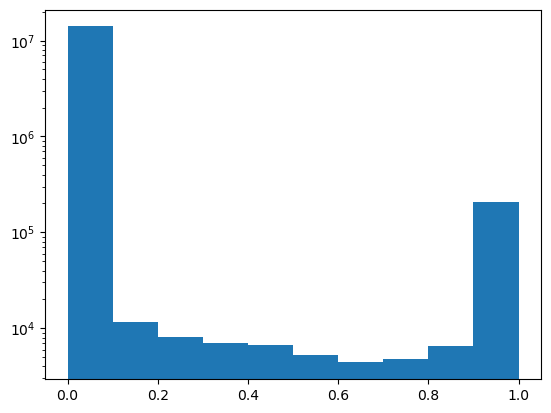

Processing 480287IND0_0281.png and saved to data/TileIndicesBoundaries/480287IND0_0281.png


  0%|          | 0/2 [00:00<?, ?it/s]

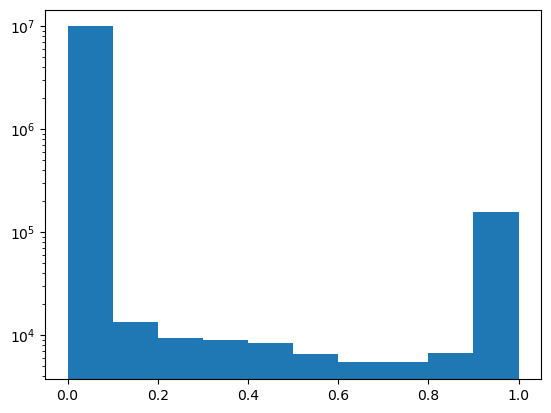

Processing 480287IND0_0288.png and saved to data/TileIndicesBoundaries/480287IND0_0288.png


  0%|          | 0/3 [00:00<?, ?it/s]

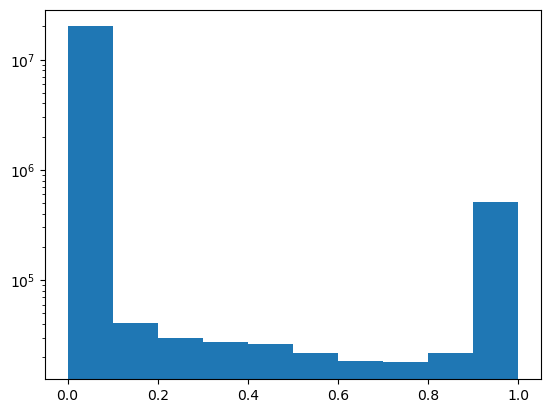

Processing 480287IND0_0382.png and saved to data/TileIndicesBoundaries/480287IND0_0382.png


  0%|          | 0/2 [00:00<?, ?it/s]

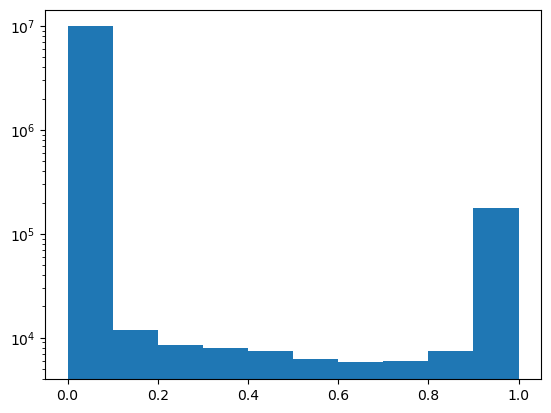

Processing 480287IND0_0985.png and saved to data/TileIndicesBoundaries/480287IND0_0985.png


  0%|          | 0/3 [00:00<?, ?it/s]

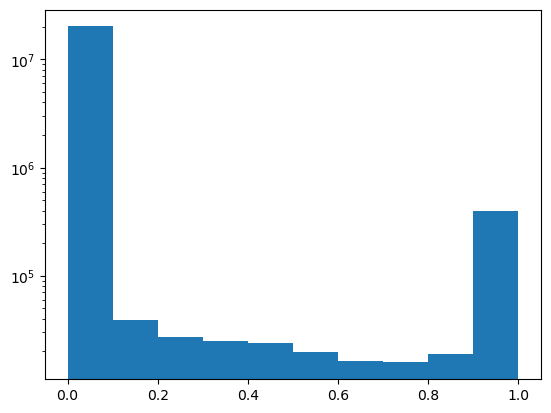

Processing 480296IND0_0982.png and saved to data/TileIndicesBoundaries/480296IND0_0982.png


  0%|          | 0/3 [00:00<?, ?it/s]

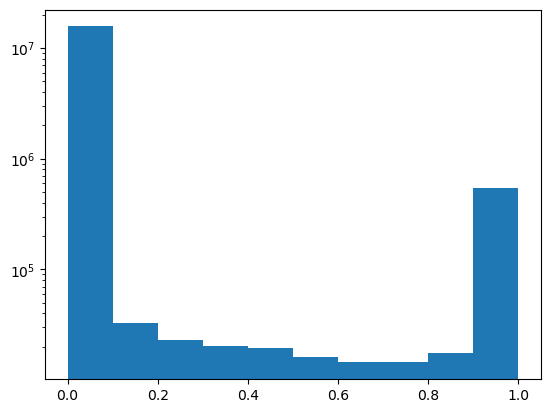

Processing 480296IND0_0985.png and saved to data/TileIndicesBoundaries/480296IND0_0985.png


  0%|          | 0/3 [00:00<?, ?it/s]

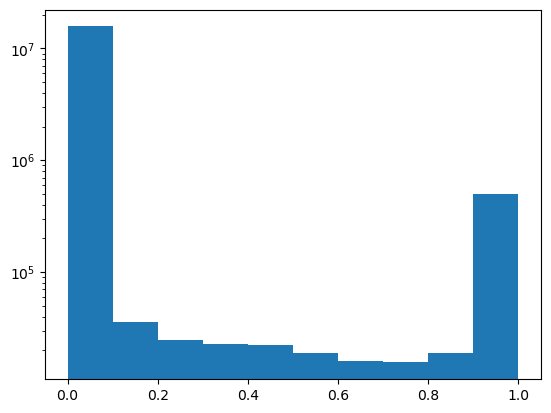

Processing 480296IND0_0987.png and saved to data/TileIndicesBoundaries/480296IND0_0987.png


  0%|          | 0/3 [00:00<?, ?it/s]

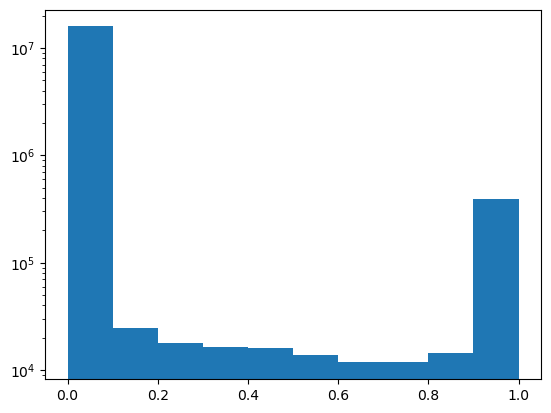

Processing 480296IND0_1279.png and saved to data/TileIndicesBoundaries/480296IND0_1279.png


  0%|          | 0/3 [00:00<?, ?it/s]

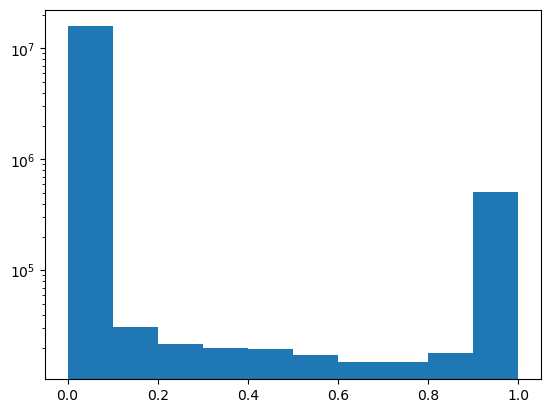

Processing 480304IND0_0182.png and saved to data/TileIndicesBoundaries/480304IND0_0182.png


  0%|          | 0/2 [00:00<?, ?it/s]

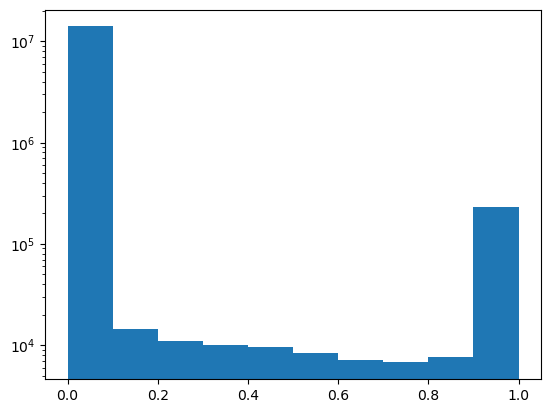

Processing 480304IND0_1077.png and saved to data/TileIndicesBoundaries/480304IND0_1077.png


  0%|          | 0/2 [00:00<?, ?it/s]

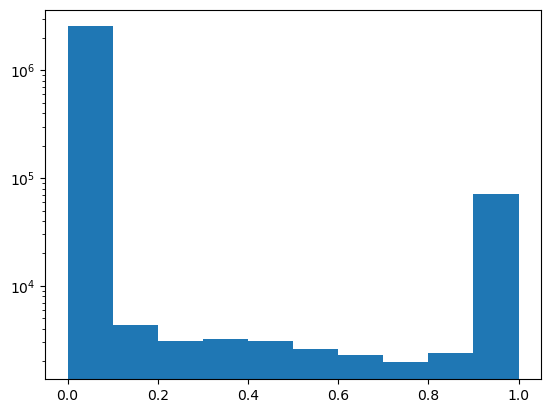

Processing 480304IND0_1287.png and saved to data/TileIndicesBoundaries/480304IND0_1287.png


  0%|          | 0/2 [00:00<?, ?it/s]

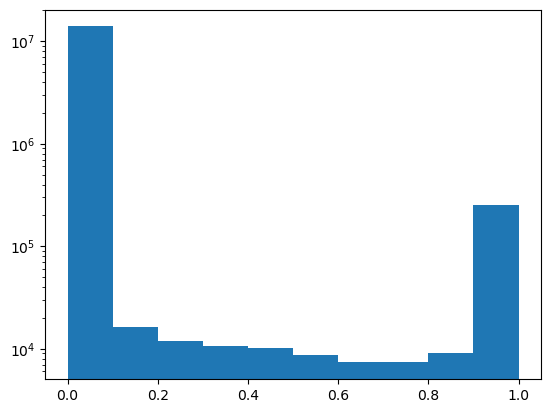

Processing 480307IND0_0686.png and saved to data/TileIndicesBoundaries/480307IND0_0686.png


  0%|          | 0/2 [00:00<?, ?it/s]

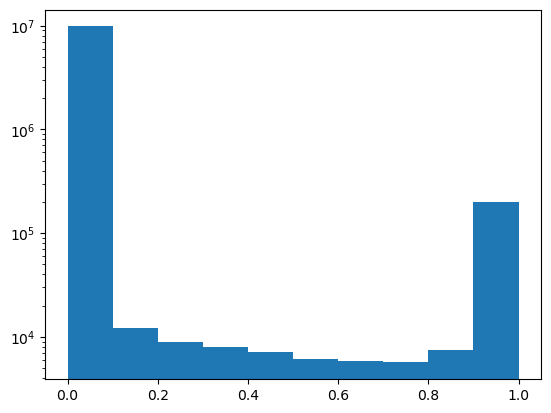

Processing 48039CIND0.png and saved to data/TileIndicesBoundaries/48039CIND0.png


C:\Users\franc\anaconda3\envs\deeplearning\lib\site-packages\PIL\Image.py:2921: DecompressionBombWarning: Image size (107381166 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  0%|          | 0/6 [00:00<?, ?it/s]

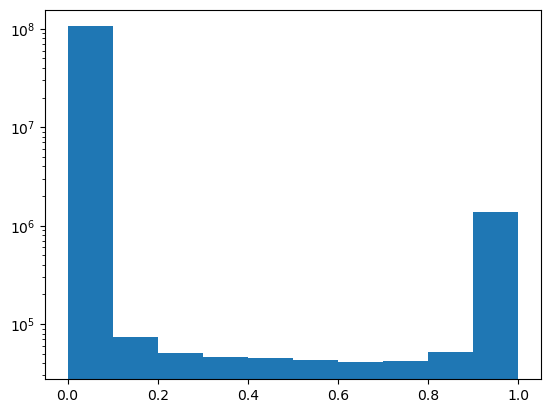

Processing 48071CIND0A.png and saved to data/TileIndicesBoundaries/48071CIND0A.png


C:\Users\franc\anaconda3\envs\deeplearning\lib\site-packages\PIL\Image.py:2921: DecompressionBombWarning: Image size (149040000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  0%|          | 0/8 [00:00<?, ?it/s]

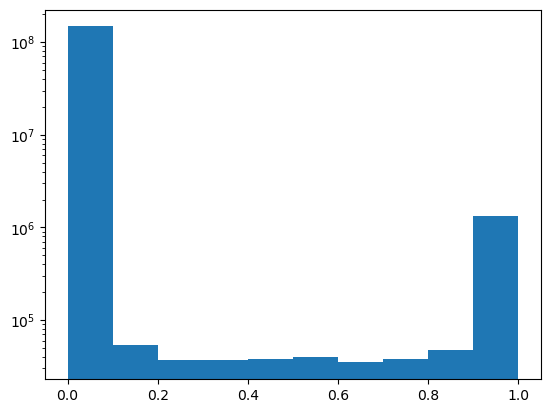

Processing 48157CIND0.png and saved to data/TileIndicesBoundaries/48157CIND0.png


C:\Users\franc\anaconda3\envs\deeplearning\lib\site-packages\PIL\Image.py:2921: DecompressionBombWarning: Image size (120734289 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  0%|          | 0/6 [00:00<?, ?it/s]

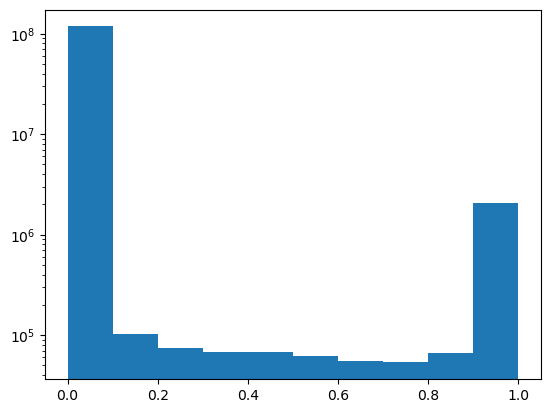

Processing 48157CIND0A.png and saved to data/TileIndicesBoundaries/48157CIND0A.png


C:\Users\franc\anaconda3\envs\deeplearning\lib\site-packages\PIL\Image.py:2921: DecompressionBombWarning: Image size (149238064 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  0%|          | 0/8 [00:00<?, ?it/s]

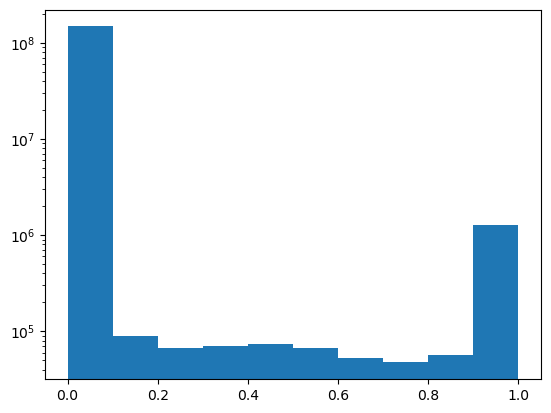

Processing 48157CIND0B.png and saved to data/TileIndicesBoundaries/48157CIND0B.png


  0%|          | 0/8 [00:00<?, ?it/s]

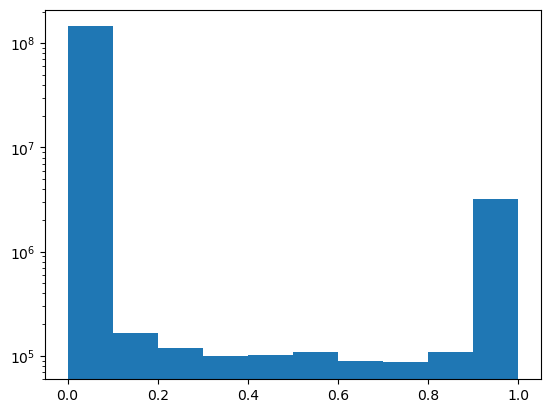

Processing 48201CIND0.png and saved to data/TileIndicesBoundaries/48201CIND0.png


C:\Users\franc\anaconda3\envs\deeplearning\lib\site-packages\PIL\Image.py:2921: DecompressionBombWarning: Image size (121452044 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  0%|          | 0/6 [00:00<?, ?it/s]

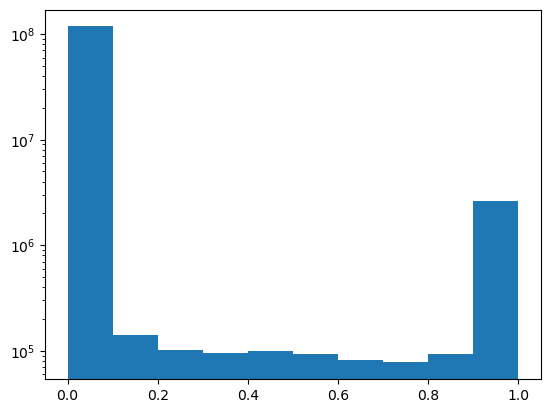

Processing 48201CIND0A.png and saved to data/TileIndicesBoundaries/48201CIND0A.png


C:\Users\franc\anaconda3\envs\deeplearning\lib\site-packages\PIL\Image.py:2921: DecompressionBombWarning: Image size (144729228 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  0%|          | 0/7 [00:00<?, ?it/s]

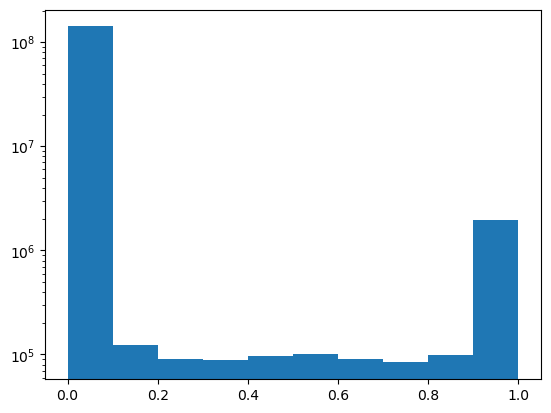

Processing 48201CIND0B.png and saved to data/TileIndicesBoundaries/48201CIND0B.png


  0%|          | 0/8 [00:00<?, ?it/s]

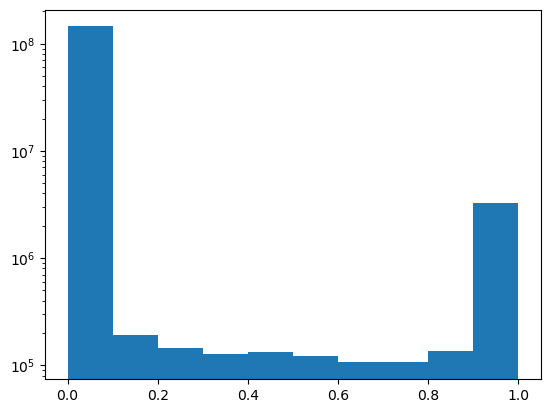

Processing 48201CIND0C.png and saved to data/TileIndicesBoundaries/48201CIND0C.png


  0%|          | 0/8 [00:00<?, ?it/s]

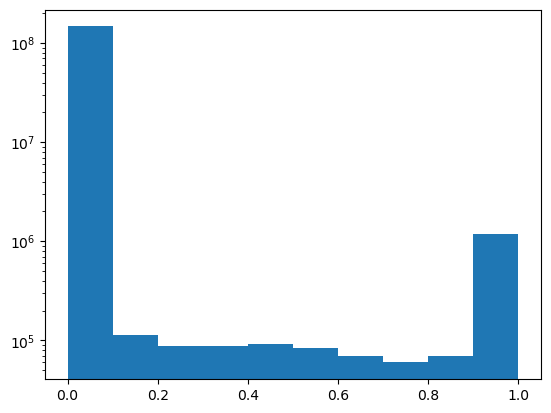

Processing 48201CIND0D.png and saved to data/TileIndicesBoundaries/48201CIND0D.png


  0%|          | 0/8 [00:00<?, ?it/s]

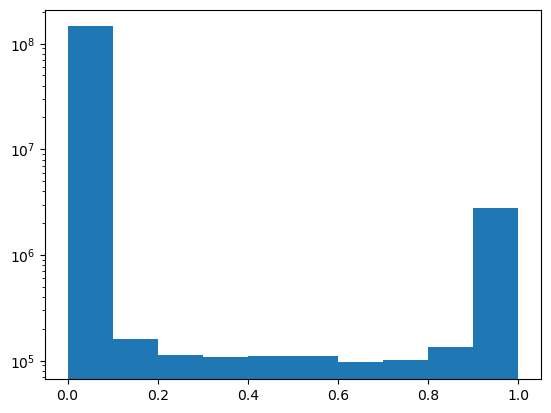

Processing 48201CIND0E.png and saved to data/TileIndicesBoundaries/48201CIND0E.png


  0%|          | 0/8 [00:00<?, ?it/s]

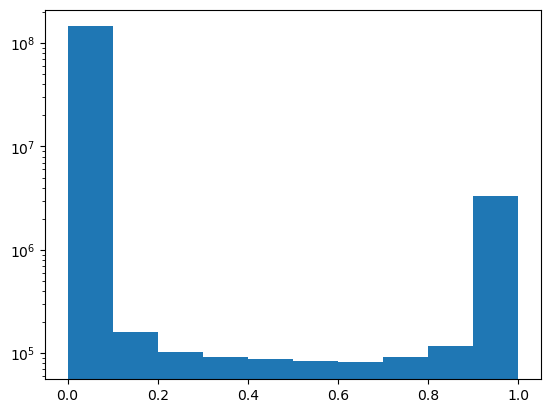

Processing 48201CIND0F.png and saved to data/TileIndicesBoundaries/48201CIND0F.png


  0%|          | 0/8 [00:00<?, ?it/s]

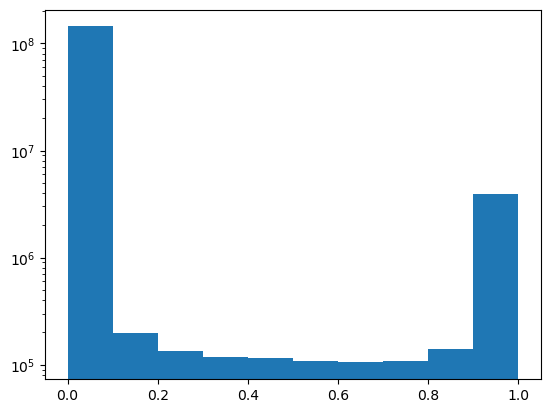

Processing 48201CIND0_0990.png and saved to data/TileIndicesBoundaries/48201CIND0_0990.png


  0%|          | 0/3 [00:00<?, ?it/s]

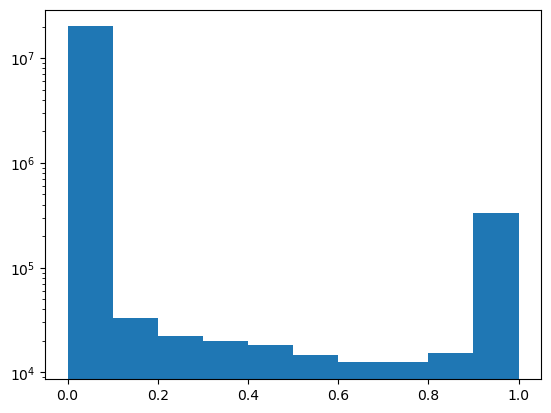

Processing 48201CIND0_0992.png and saved to data/TileIndicesBoundaries/48201CIND0_0992.png


C:\Users\franc\anaconda3\envs\deeplearning\lib\site-packages\PIL\Image.py:2921: DecompressionBombWarning: Image size (151368000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  0%|          | 0/8 [00:00<?, ?it/s]

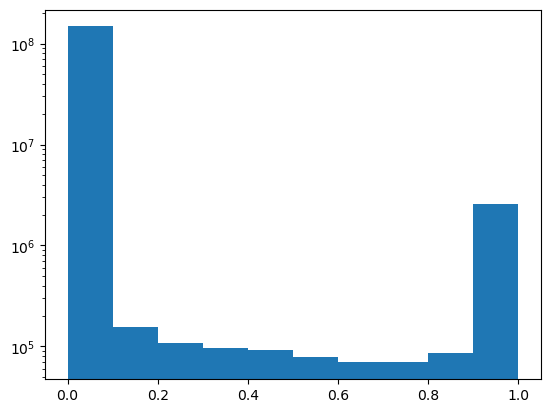

Processing 48201CIND0_1196.png and saved to data/TileIndicesBoundaries/48201CIND0_1196.png


C:\Users\franc\anaconda3\envs\deeplearning\lib\site-packages\PIL\Image.py:2921: DecompressionBombWarning: Image size (120780563 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  0%|          | 0/6 [00:00<?, ?it/s]

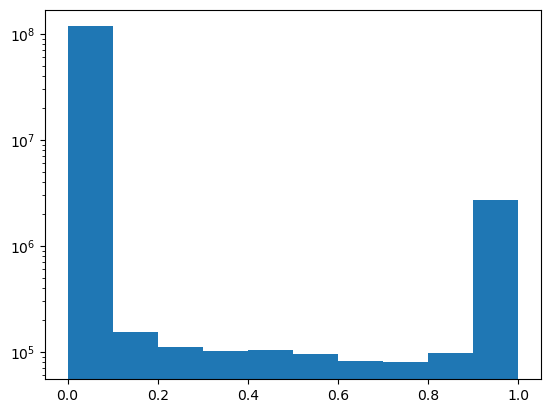

Processing 48339CIND0.png and saved to data/TileIndicesBoundaries/48339CIND0.png


C:\Users\franc\anaconda3\envs\deeplearning\lib\site-packages\PIL\Image.py:2921: DecompressionBombWarning: Image size (120349218 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  0%|          | 0/6 [00:00<?, ?it/s]

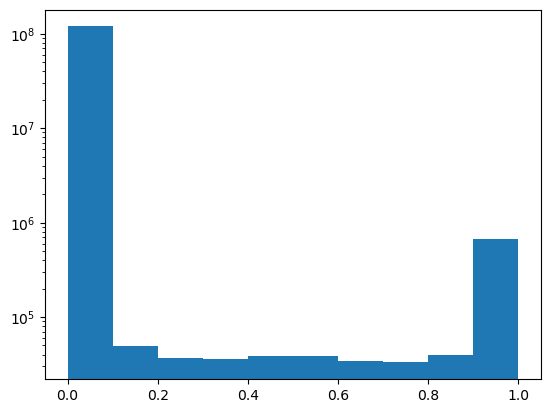

Processing 48473CIND0A.png and saved to data/TileIndicesBoundaries/48473CIND0A.png


C:\Users\franc\anaconda3\envs\deeplearning\lib\site-packages\PIL\Image.py:2921: DecompressionBombWarning: Image size (148978345 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  0%|          | 0/8 [00:00<?, ?it/s]

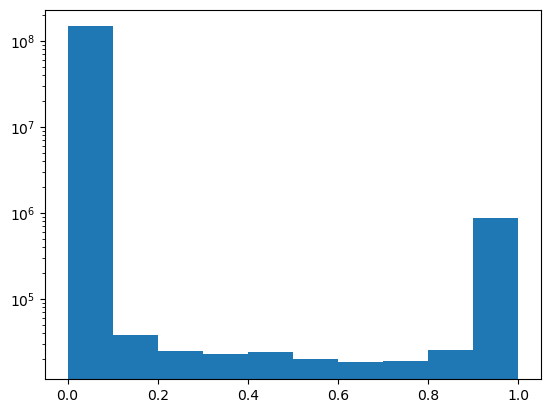

Processing 485456IND0_0279.png and saved to data/TileIndicesBoundaries/485456IND0_0279.png


  0%|          | 0/2 [00:00<?, ?it/s]

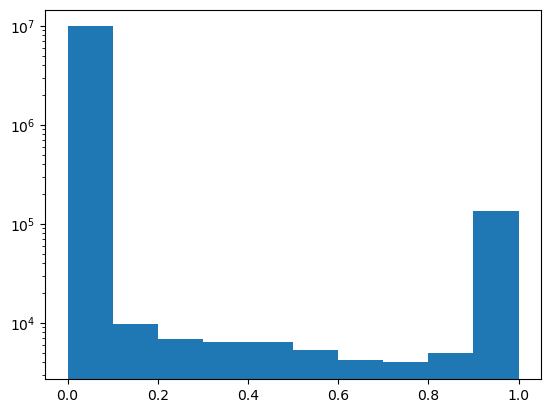

Processing 485456IND0_0982.png and saved to data/TileIndicesBoundaries/485456IND0_0982.png


  0%|          | 0/2 [00:00<?, ?it/s]

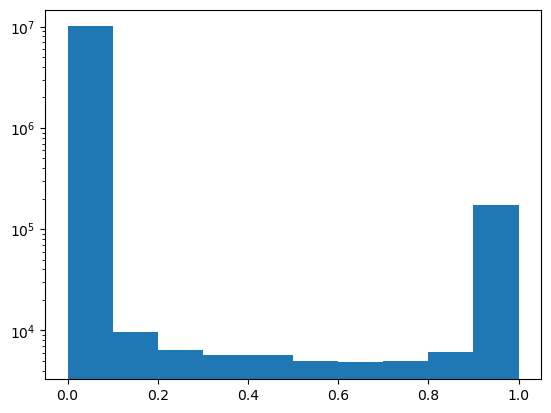

Processing 485456IND0_1185.png and saved to data/TileIndicesBoundaries/485456IND0_1185.png


  0%|          | 0/2 [00:00<?, ?it/s]

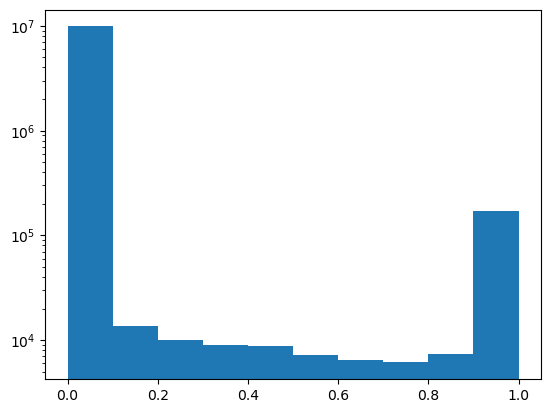

Processing 485468IND0_0483.png and saved to data/TileIndicesBoundaries/485468IND0_0483.png


  0%|          | 0/2 [00:00<?, ?it/s]

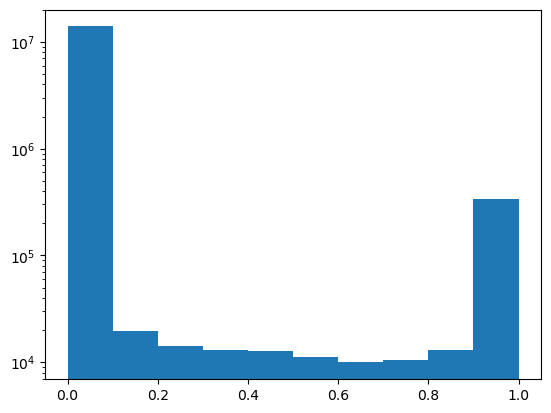

Processing 485487IND0_1185.png and saved to data/TileIndicesBoundaries/485487IND0_1185.png


  0%|          | 0/2 [00:00<?, ?it/s]

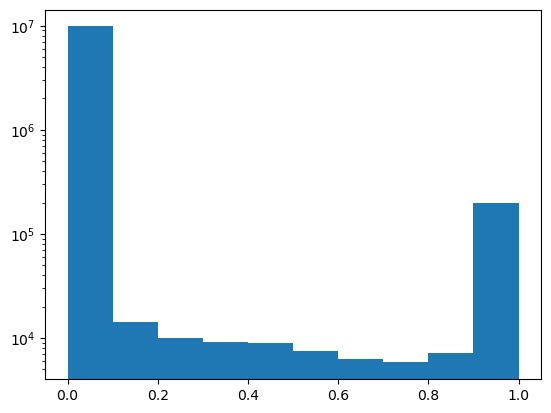

Processing 485488IND0.png and saved to data/TileIndicesBoundaries/485488IND0.png


C:\Users\franc\anaconda3\envs\deeplearning\lib\site-packages\PIL\Image.py:2921: DecompressionBombWarning: Image size (105509759 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  0%|          | 0/6 [00:00<?, ?it/s]

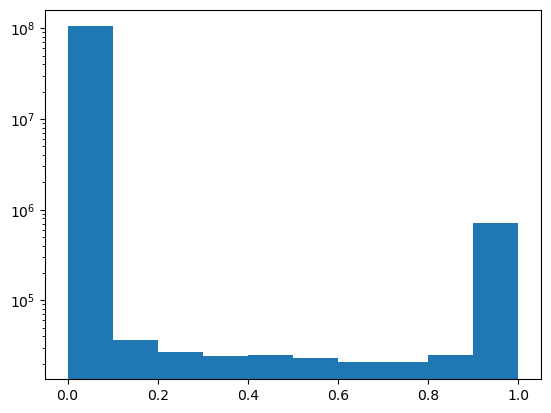

Processing 485488IND0_0583.png and saved to data/TileIndicesBoundaries/485488IND0_0583.png


  0%|          | 0/2 [00:00<?, ?it/s]

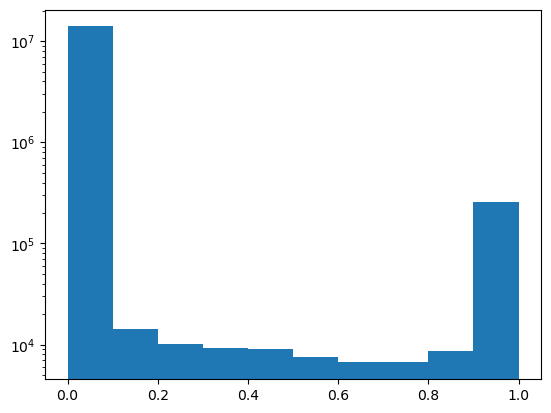

Processing 485488IND0_0990.png and saved to data/TileIndicesBoundaries/485488IND0_0990.png


C:\Users\franc\anaconda3\envs\deeplearning\lib\site-packages\PIL\Image.py:2921: DecompressionBombWarning: Image size (108445808 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  0%|          | 0/6 [00:00<?, ?it/s]

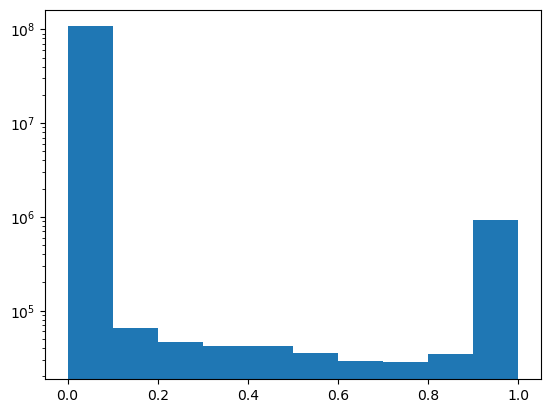

Processing 485516IND0_0281.png and saved to data/TileIndicesBoundaries/485516IND0_0281.png


  0%|          | 0/2 [00:00<?, ?it/s]

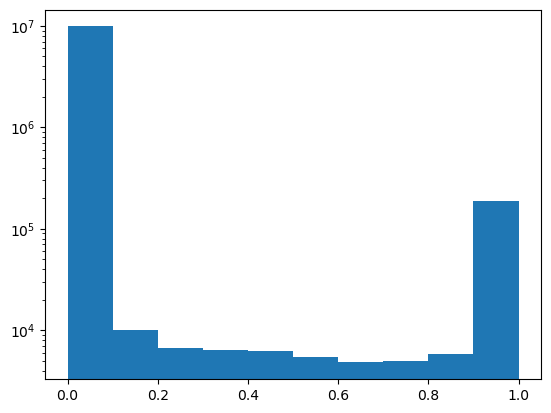

In [6]:
input_folder = f"data/TileIndices_Sharpened/"
output_folder = f"data/TileIndicesBoundaries/"
    
 # Iterate over the files in the input folder
for filename in os.listdir(input_folder):
    # Check if the file has a supported image extension
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
        # Open the image file
        image_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename[:-3] + "png")
        print(f"Processing {filename} and saved to {output_path}")
        
        # Apply the process function to the image
        processed_image = split_and_run_cnn(image_path, model)
        
        plt.hist(processed_image.flatten())
        plt.yscale("log")
        plt.show()
                
        image = np.where(processed_image > 0.1, 255, 0)
        
        # Save the processed image to the output folder
        cv2.imwrite(output_path, image.astype(np.uint8))